In [ ]:
"""
Stable Multi-Label Segmentation Trainer (IoU=0-proof)

- 18 classes (no background)
- BCEWithLogits(pos_weight, clamped) + Dice
- AMP warm-up, NaN/Inf guards, gradient clipping
- Cosine LR with warm-up (AdamW)
- Robust mask-shape alignment (dataset + train/eval + loss)
- Best checkpoint + early stopping
"""

import os, json, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import cv2
from PIL import Image, ImageDraw
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

# ----------------------- Config -----------------------

class Config:
    # === EDIT THESE PATHS ===
    TRAIN_IMG_DIR = r"D:\Mohamed Ragab\MSc\Dissertation\ML\Multi-class\dataset\images\train"
    TRAIN_JSON    = r"D:\Mohamed Ragab\MSc\Dissertation\ML\Multi-class\dataset\annotations\train"
    VAL_IMG_DIR   = r"D:\Mohamed Ragab\MSc\Dissertation\ML\Multi-class\dataset\images\validation"
    VAL_JSON      = r"D:\Mohamed Ragab\MSc\Dissertation\ML\Multi-class\dataset\annotations\validation"

    SAVE_PATH = "best_model_stable.pth"

    # 18 classes (no 'background')
    CLASS_NAMES = [
        'Crack','ACrack','Wetspot','Efflorescence','Rust','Rockpocket','Hollowareas',
        'Climbingplants','Weathering','Restformwork','Spalling','Graffiti',
        'ExposedRebars','Bearing','EJoint','Drainage','PEquipment','JTape'
    ]

    IMAGE_SIZE = 384
    EPOCHS = 30
    BATCH_SIZE = 4
    NUM_WORKERS = 0           # Windows-safe
    PIN_MEMORY = False        # Windows-safe
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    LR = 3e-4
    WEIGHT_DECAY = 1e-4
    WARMUP_EPOCHS = 2
    AMP_WARMUP_EPOCHS = 3
    CLIP_NORM = 1.0

    PATIENCE = 6
    POS_WEIGHT_MAX = 1e4      # clamp rare-class pos_weight to keep BCE stable

cfg = Config()

# Normalize raw labels from JSON to canonical names used in CLASS_NAMES
LABEL_NORMALIZE = {
    'crack':'Crack','acrack':'ACrack','wetspot':'Wetspot','efflorescence':'Efflorescence',
    'rust':'Rust','rockpocket':'Rockpocket','hollowareas':'Hollowareas','hollowarea':'Hollowareas',
    'climbingplants':'Climbingplants','climbingplant':'Climbingplants','weathering':'Weathering',
    'restformwork':'Restformwork','spalling':'Spalling','graffiti':'Graffiti',
    'exposedrebars':'ExposedRebars','exposed_rebars':'ExposedRebars',
    'bearing':'Bearing','ejoint':'EJoint','expansionjoint':'EJoint','drainage':'Drainage',
    'pequipment':'PEquipment','protectiveequipment':'PEquipment','jtape':'JTape','jointtape':'JTape',
}
NAME_TO_IDX = {n:i for i,n in enumerate(cfg.CLASS_NAMES)}
NUM_CLASSES = len(cfg.CLASS_NAMES)

# ----------------------- Utils -----------------------

def set_seed(seed=42):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
set_seed(42)

def polygons_to_mask(shapes, H, W):
    """HWC multi-label mask with 18 channels (no background)."""
    mask = np.zeros((H, W, NUM_CLASSES), dtype=np.float32)
    for sh in shapes:
        lb_raw = (sh.get('label','') or '').replace(' ','')
        lb = LABEL_NORMALIZE.get(lb_raw.lower(), None)
        if lb is None or lb not in NAME_TO_IDX:
            continue
        ci = NAME_TO_IDX[lb]
        pts = sh.get('points', [])
        if not pts:
            continue
        img = Image.new('L', (W, H), 0)
        draw = ImageDraw.Draw(img)
        poly = [(int(x), int(y)) for x,y in pts]
        if len(poly) >= 3:
            draw.polygon(poly, outline=1, fill=1)
        arr = np.array(img, dtype=np.float32)
        mask[:, :, ci] = np.maximum(mask[:, :, ci], arr)
    return mask

def to_bchw_masks(t, num_classes):
    """Accepts (B,C,H,W) or (B,H,W,C) or (C,H,W) or (H,W,C); returns (B,C,H,W) torch tensor."""
    if isinstance(t, np.ndarray):
        t = torch.from_numpy(t)
    if t.ndim == 4:
        if t.shape[1] == num_classes:   # (B,C,H,W)
            return t
        if t.shape[-1] == num_classes:  # (B,H,W,C)
            return t.permute(0, 3, 1, 2).contiguous()
    elif t.ndim == 3:
        if t.shape[0] == num_classes:   # (C,H,W)
            return t.unsqueeze(0)
        if t.shape[-1] == num_classes:  # (H,W,C)
            return t.permute(2, 0, 1).unsqueeze(0).contiguous()
    raise ValueError(f"Unexpected mask shape {tuple(t.shape)}; cannot align to BCHW.")

def align_to_logits(targets: torch.Tensor, logits: torch.Tensor) -> torch.Tensor:
    """
    Force targets to the exact shape/layout of logits: (B,C,H,W).
    Handles common cases: (B,H,W,C), (C,H,W), (H,W,C).
    """
    B, C, H, W = logits.shape
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    targets = targets.to(logits.device).float()

    if tuple(targets.shape) == (B, C, H, W):        # already correct
        return targets
    if targets.ndim == 4 and tuple(targets.shape) == (B, H, W, C):  # BHWC -> BCHW
        return targets.permute(0, 3, 1, 2).contiguous()
    if targets.ndim == 3 and tuple(targets.shape) == (C, H, W):     # CHW -> BCHW
        return targets.unsqueeze(0).expand(B, -1, -1, -1).contiguous()
    if targets.ndim == 3 and tuple(targets.shape) == (H, W, C):     # HWC -> BCHW
        return targets.permute(2, 0, 1).unsqueeze(0).expand(B, -1, -1, -1).contiguous()

    # Fallback using the generic helper
    return to_bchw_masks(targets, C).to(logits.device).float()

# ----------------------- Dataset -----------------------

class JSONSegDataset(Dataset):
    def __init__(self, img_dir, ann_dir, image_size=384, train=True):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.files = sorted([f for f in os.listdir(ann_dir) if f.endswith(".json")])
        self.image_size = image_size
        if train:
            self.tfm = A.Compose([
                A.Resize(image_size, image_size),
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.2),
                A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=10, p=0.3,
                                   border_mode=cv2.BORDER_REFLECT),
                A.RandomBrightnessContrast(p=0.25),
                A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
                ToTensorV2()
            ])
        else:
            self.tfm = A.Compose([
                A.Resize(image_size, image_size),
                A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        ann_file = self.files[idx]
        ann_path = os.path.join(self.ann_dir, ann_file)
        with open(ann_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        H = int(data.get('imageHeight', 0) or 0)
        W = int(data.get('imageWidth', 0) or 0)
        shapes = data.get('shapes', [])
        img_name = data.get('imagePath', os.path.splitext(ann_file)[0])

        base = os.path.splitext(os.path.basename(img_name))[0]
        img_path = None
        for ext in ('.jpg','.jpeg','.png','.JPG','.PNG','.JPEG'):
            p = os.path.join(self.img_dir, base + ext)
            if os.path.exists(p):
                img_path = p; break
        if img_path is None:
            p = os.path.join(self.img_dir, os.path.basename(img_name))
            if os.path.exists(p): img_path = p
        if img_path is None:
            raise FileNotFoundError(f"No image for {ann_file}")

        bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        if H == 0 or W == 0:
            H, W = rgb.shape[:2]

        mask_hwc = polygons_to_mask(shapes, H, W)

        aug = self.tfm(image=rgb, mask=mask_hwc)
        image = aug['image']    # torch (3,H,W)
        mask  = aug['mask']     # numpy (H,W,C) or torch (H,W,C)

        # --- FORCE CHW at dataset level ---
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        mask_t = torch.from_numpy(mask).permute(2,0,1).float()  # (C,H,W)
        mask_t = (mask_t > 0.5).float()

        image = torch.nan_to_num(image, nan=0.0, posinf=1.0, neginf=0.0)
        mask_t = torch.clamp(mask_t, 0.0, 1.0)
        return image, mask_t

# ----------------------- Losses -----------------------

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2.0 * (probs * targets).sum(dim=(0,2,3))
        den = (probs + targets).sum(dim=(0,2,3)).clamp_min(self.eps)
        return 1.0 - (num / den).mean()

def make_loss(pos_weight_vec: torch.Tensor):
    # Important: reshape to broadcast across (N,C,H,W) on channel dim
    # shape: (1, C, 1, 1) so it matches logits/targets (N,C,H,W)
    pos_w = pos_weight_vec.clone().detach().float().to(cfg.DEVICE).view(1, NUM_CLASSES, 1, 1)
    dice = DiceLoss()
    _printed_once = {"done": False}

    def loss_fn(logits, targets):
        # FINAL SHAPE GUARD (so BCE never crashes):
        targets = align_to_logits(targets, logits).float()

        # One-time shape debug (first batch only)
        if not _printed_once["done"]:
            print("[LOSS DEBUG] logits:", tuple(logits.shape), "targets:", tuple(targets.shape),
                  "| pos_w:", tuple(pos_w.shape))
            _printed_once["done"] = True

        # Hard assert
        assert logits.shape == targets.shape, \
            f"[LOSS] Shapes must match. Logits={tuple(logits.shape)} Targets={tuple(targets.shape)}"

        # BCE with properly-broadcast pos_weight
        bce = F.binary_cross_entropy_with_logits(
            logits, targets, reduction='none', pos_weight=pos_w
        ).mean()

        return bce + dice(logits, targets)
    return loss_fn

# ----------------------- Pos-weight Estimation -----------------------

@torch.no_grad()
def estimate_pos_weight(loader, max_batches=256):
    pos = torch.zeros(NUM_CLASSES, dtype=torch.float64)
    tot = torch.zeros(NUM_CLASSES, dtype=torch.float64)
    for i, (_, masks) in enumerate(loader):
        masks = to_bchw_masks(masks, NUM_CLASSES)  # robust shape for counting
        b, _, H, W = masks.shape
        pos += masks.sum(dim=(0,2,3)).double()
        tot += (b * H * W)
        if i+1 >= max_batches:
            break
    pos = torch.clamp(pos, min=1.0)
    neg = torch.clamp(tot - pos, min=1.0)
    pw = (neg / pos).float()
    return pw

# ----------------------- Metrics -----------------------

@torch.no_grad()
def evaluate(model, loader, threshold=0.5):
    model.eval()
    inter = torch.zeros(NUM_CLASSES, dtype=torch.float64, device=cfg.DEVICE)
    union = torch.zeros(NUM_CLASSES, dtype=torch.float64, device=cfg.DEVICE)
    for imgs, masks in tqdm(loader, desc="Validation", leave=False):
        imgs = imgs.to(cfg.DEVICE, non_blocking=True)
        masks = masks.to(cfg.DEVICE, non_blocking=True).float()

        logits = model(imgs)
        masks  = align_to_logits(masks, logits)     # align targets to logits
        probs  = torch.sigmoid(logits)
        preds  = (probs > threshold).float()

        inter += (preds * masks).sum(dim=(0,2,3)).double()
        union += ((preds + masks) > 0).float().sum(dim=(0,2,3)).double()

    iou = (inter / (union.clamp_min(1e-6))).detach().cpu().numpy()
    miou = float(np.mean(iou))
    return miou, iou

# ----------------------- Training Loop -----------------------

def train():
    print("==> Building datasets")
    train_ds = JSONSegDataset(cfg.TRAIN_IMG_DIR, cfg.TRAIN_JSON, image_size=cfg.IMAGE_SIZE, train=True)
    val_ds   = JSONSegDataset(cfg.VAL_IMG_DIR,   cfg.VAL_JSON,   image_size=cfg.IMAGE_SIZE, train=False)

    train_loader_for_pw = DataLoader(train_ds, batch_size=2, shuffle=True,
                                     num_workers=0, pin_memory=False, drop_last=False)
    print("==> Estimating pos_weight (class imbalance)")
    pos_weight = estimate_pos_weight(train_loader_for_pw)
    pos_weight = torch.clamp(pos_weight, max=cfg.POS_WEIGHT_MAX)
    print("pos_weight (clamped):", {cfg.CLASS_NAMES[i]: round(float(pos_weight[i]),2) for i in range(NUM_CLASSES)})

    train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True,
                              num_workers=cfg.NUM_WORKERS, pin_memory=cfg.PIN_MEMORY, drop_last=True)
    val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False,
                              num_workers=0, pin_memory=False)

    print("==> Building model")
    model = smp.FPN(
        encoder_name="efficientnet-b4",
        encoder_weights="imagenet",
        in_channels=3,
        classes=NUM_CLASSES
    ).to(cfg.DEVICE)

    criterion = make_loss(pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LR, weight_decay=cfg.WEIGHT_DECAY)
    scaler = torch.cuda.amp.GradScaler(enabled=(cfg.DEVICE=='cuda'))

    best_miou = 0.0
    epochs_no_improve = 0

    def lr_for_epoch(ep):
        if ep < cfg.WARMUP_EPOCHS:
            return cfg.LR * float(ep+1)/float(cfg.WARMUP_EPOCHS)
        t = (ep - cfg.WARMUP_EPOCHS) / max(1, (cfg.EPOCHS - cfg.WARMUP_EPOCHS))
        return 0.5 * cfg.LR * (1 + math.cos(math.pi * t))

    for epoch in range(cfg.EPOCHS):
        model.train()
        use_amp = (cfg.DEVICE=='cuda') and (epoch >= cfg.AMP_WARMUP_EPOCHS)

        lr = lr_for_epoch(epoch)
        for g in optimizer.param_groups:
            g['lr'] = lr

        running = 0.0
        logits_means, prob_means, mask_ratio_track = [], [], []

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.EPOCHS}")
        for batch_idx, (imgs, masks) in enumerate(pbar):
            imgs = imgs.to(cfg.DEVICE, non_blocking=True)
            masks = masks.to(cfg.DEVICE, non_blocking=True).float()

            # one-time debug on epoch 0 first step
            if epoch == 0 and batch_idx == 0:
                print("[TRAIN DEBUG] imgs:", tuple(imgs.shape), "masks(before):", tuple(masks.shape))

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=use_amp):
                logits = model(imgs)
                if torch.isnan(logits).any() or torch.isinf(logits).any():
                    continue

                # --- FORCE ALIGNMENT right here ---
                masks_aligned = align_to_logits(masks, logits)
                # assert before loss so we catch any mismatch early
                assert logits.shape == masks_aligned.shape, \
                    f"[TRAIN] Logits={tuple(logits.shape)} Targets={tuple(masks_aligned.shape)}"

                loss = criterion(logits, masks_aligned)

            if torch.isnan(loss) or torch.isinf(loss):
                optimizer.zero_grad(set_to_none=True)
                continue

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=cfg.CLIP_NORM)
            scaler.step(optimizer)
            scaler.update()

            running += float(loss.detach().cpu())

            with torch.no_grad():
                probs = torch.sigmoid(logits)
                logits_means.append(float(logits.mean().detach().cpu()))
                prob_means.append(float(probs.mean().detach().cpu()))

                # class-positive ratio in batch
                per_class = masks_aligned.sum(dim=(0,2,3)).detach().cpu().numpy()
                denom = masks_aligned.shape[0] * masks_aligned.shape[2] * masks_aligned.shape[3]
                mask_ratio_track.append(per_class / max(1,denom))

            pbar.set_postfix(loss=running/ (len(logits_means) or 1), lr=lr)

        mr = np.mean(mask_ratio_track, axis=0) if len(mask_ratio_track) else None
        print(f"📊 Train Pos Ratio per Class (mean): {np.round(mr,6) if mr is not None else 'N/A'}")
        print(f"📊 Train Logits Mean: {np.nanmean(logits_means):.5f} | Probs Mean: {np.nanmean(prob_means):.5f}")
        print(f"📉 LR: {lr:.6e}")

        miou, iou = evaluate(model, val_loader, threshold=0.5)
        print(f"✅ Val mIoU: {miou:.4f}")
        for i, v in enumerate(iou):
            print(f"  {cfg.CLASS_NAMES[i]:15s} IoU: {v:.3f}")

        if miou > best_miou + 1e-6:
            best_miou = miou
            epochs_no_improve = 0
            torch.save({
                "state_dict": model.state_dict(),
                "classes": cfg.CLASS_NAMES,
                "pos_weight": pos_weight.cpu().numpy(),
                "image_size": cfg.IMAGE_SIZE,
                "best_mIoU": best_miou,
                "epoch": epoch+1,
            }, cfg.SAVE_PATH)
            print(f"💾 Saved best model: {cfg.SAVE_PATH} (mIoU={best_miou:.4f})")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= cfg.PATIENCE:
                print(f"⏹ Early stopping at epoch {epoch+1} (no improvement {cfg.PATIENCE} epochs).")
                break

    print(f"✔ Done. Best mIoU: {best_miou:.4f}")

if __name__ == "__main__":
    train()

==> Building datasets
==> Estimating pos_weight (class imbalance)
pos_weight (clamped): {'Crack': 366.7, 'ACrack': 73.75, 'Wetspot': 37.19, 'Efflorescence': 38.66, 'Rust': 47.2, 'Rockpocket': 357.35, 'Hollowareas': 40.71, 'Climbingplants': 10000.0, 'Weathering': 6.76, 'Restformwork': 378.85, 'Spalling': 44.31, 'Graffiti': 53.68, 'ExposedRebars': 1499.76, 'Bearing': 123.69, 'EJoint': 72.16, 'Drainage': 107.84, 'PEquipment': 23.19, 'JTape': 330.32}
==> Building model


Epoch 1/30:   0%|          | 0/1733 [00:00<?, ?it/s]

[TRAIN DEBUG] imgs: (4, 3, 384, 384) masks(before): (4, 18, 384, 384)
[LOSS DEBUG] logits: (4, 18, 384, 384) targets: (4, 18, 384, 384) | pos_w: (1, 18, 1, 1)


Epoch 1/30: 100%|██████████| 1733/1733 [1:25:32<00:00,  2.96s/it, loss=1.97, lr=0.00015]


📊 Train Pos Ratio per Class (mean): [0.003272 0.014252 0.026334 0.02085  0.022514 0.002785 0.028162 0.
 0.134782 0.003029 0.025866 0.020172 0.001445 0.012379 0.011542 0.009978
 0.040257 0.003624]
📊 Train Logits Mean: -3.10791 | Probs Mean: 0.20491
📉 LR: 1.500000e-04


✅ Val mIoU: 0.1540
  Crack           IoU: 0.018
  ACrack          IoU: 0.138
  Wetspot         IoU: 0.094
  Efflorescence   IoU: 0.088
  Rust            IoU: 0.260
  Rockpocket      IoU: 0.017
  Hollowareas     IoU: 0.228
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.312
  Restformwork    IoU: 0.055
  Spalling        IoU: 0.131
  Graffiti        IoU: 0.333
  ExposedRebars   IoU: 0.023
  Bearing         IoU: 0.235
  EJoint          IoU: 0.343
  Drainage        IoU: 0.152
  PEquipment      IoU: 0.273
  JTape           IoU: 0.073
💾 Saved best model: best_model_stable.pth (mIoU=0.1540)


Epoch 2/30: 100%|██████████| 1733/1733 [1:49:13<00:00,  3.78s/it, loss=1.76, lr=0.0003]  


📊 Train Pos Ratio per Class (mean): [0.003263 0.014195 0.026334 0.020889 0.022521 0.002758 0.02813  0.
 0.134923 0.003032 0.02587  0.02013  0.00145  0.01236  0.011646 0.009965
 0.040173 0.003627]
📊 Train Logits Mean: -3.91762 | Probs Mean: 0.15701
📉 LR: 3.000000e-04


✅ Val mIoU: 0.1472
  Crack           IoU: 0.017
  ACrack          IoU: 0.132
  Wetspot         IoU: 0.071
  Efflorescence   IoU: 0.100
  Rust            IoU: 0.174
  Rockpocket      IoU: 0.040
  Hollowareas     IoU: 0.240
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.267
  Restformwork    IoU: 0.100
  Spalling        IoU: 0.171
  Graffiti        IoU: 0.361
  ExposedRebars   IoU: 0.025
  Bearing         IoU: 0.281
  EJoint          IoU: 0.134
  Drainage        IoU: 0.177
  PEquipment      IoU: 0.288
  JTape           IoU: 0.071


Epoch 3/30: 100%|██████████| 1733/1733 [2:12:17<00:00,  4.58s/it, loss=1.62, lr=0.0003]  


📊 Train Pos Ratio per Class (mean): [0.003266 0.014249 0.026364 0.020874 0.022568 0.002771 0.028164 0.
 0.135021 0.003023 0.025856 0.020199 0.00145  0.012421 0.01164  0.009981
 0.04028  0.003619]
📊 Train Logits Mean: -4.40587 | Probs Mean: 0.13662
📉 LR: 3.000000e-04


✅ Val mIoU: 0.1873
  Crack           IoU: 0.030
  ACrack          IoU: 0.322
  Wetspot         IoU: 0.107
  Efflorescence   IoU: 0.173
  Rust            IoU: 0.271
  Rockpocket      IoU: 0.027
  Hollowareas     IoU: 0.217
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.302
  Restformwork    IoU: 0.083
  Spalling        IoU: 0.185
  Graffiti        IoU: 0.454
  ExposedRebars   IoU: 0.056
  Bearing         IoU: 0.214
  EJoint          IoU: 0.261
  Drainage        IoU: 0.177
  PEquipment      IoU: 0.431
  JTape           IoU: 0.061
💾 Saved best model: best_model_stable.pth (mIoU=0.1873)


Epoch 4/30: 100%|██████████| 1733/1733 [1:11:05<00:00,  2.46s/it, loss=1.54, lr=0.000299]


📊 Train Pos Ratio per Class (mean): [0.003265 0.01426  0.026418 0.020948 0.022561 0.002765 0.028192 0.
 0.134829 0.003032 0.025856 0.020159 0.001438 0.012348 0.011624 0.009998
 0.040117 0.003625]
📊 Train Logits Mean: -4.80924 | Probs Mean: 0.12464
📉 LR: 2.990568e-04


✅ Val mIoU: 0.1482
  Crack           IoU: 0.023
  ACrack          IoU: 0.172
  Wetspot         IoU: 0.108
  Efflorescence   IoU: 0.098
  Rust            IoU: 0.218
  Rockpocket      IoU: 0.030
  Hollowareas     IoU: 0.209
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.269
  Restformwork    IoU: 0.066
  Spalling        IoU: 0.164
  Graffiti        IoU: 0.386
  ExposedRebars   IoU: 0.029
  Bearing         IoU: 0.193
  EJoint          IoU: 0.118
  Drainage        IoU: 0.229
  PEquipment      IoU: 0.293
  JTape           IoU: 0.062


Epoch 5/30: 100%|██████████| 1733/1733 [1:10:36<00:00,  2.44s/it, loss=1.49, lr=0.000296]


📊 Train Pos Ratio per Class (mean): [0.003269 0.014234 0.026349 0.02088  0.02255  0.002748 0.028065 0.
 0.135024 0.003001 0.025898 0.020161 0.00144  0.012362 0.011669 0.009941
 0.040267 0.003635]
📊 Train Logits Mean: -5.12851 | Probs Mean: 0.11541
📉 LR: 2.962392e-04


✅ Val mIoU: 0.1845
  Crack           IoU: 0.024
  ACrack          IoU: 0.217
  Wetspot         IoU: 0.110
  Efflorescence   IoU: 0.132
  Rust            IoU: 0.203
  Rockpocket      IoU: 0.045
  Hollowareas     IoU: 0.365
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.329
  Restformwork    IoU: 0.081
  Spalling        IoU: 0.190
  Graffiti        IoU: 0.378
  ExposedRebars   IoU: 0.041
  Bearing         IoU: 0.273
  EJoint          IoU: 0.229
  Drainage        IoU: 0.304
  PEquipment      IoU: 0.303
  JTape           IoU: 0.098


Epoch 6/30: 100%|██████████| 1733/1733 [1:10:30<00:00,  2.44s/it, loss=1.43, lr=0.000292]


📊 Train Pos Ratio per Class (mean): [0.00326  0.014145 0.026319 0.020862 0.022566 0.002771 0.028121 0.
 0.134839 0.003032 0.025853 0.020195 0.001448 0.012356 0.011732 0.009981
 0.040251 0.003632]
📊 Train Logits Mean: -5.58732 | Probs Mean: 0.10683
📉 LR: 2.915825e-04


✅ Val mIoU: 0.1797
  Crack           IoU: 0.025
  ACrack          IoU: 0.149
  Wetspot         IoU: 0.122
  Efflorescence   IoU: 0.098
  Rust            IoU: 0.241
  Rockpocket      IoU: 0.031
  Hollowareas     IoU: 0.307
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.265
  Restformwork    IoU: 0.063
  Spalling        IoU: 0.167
  Graffiti        IoU: 0.458
  ExposedRebars   IoU: 0.036
  Bearing         IoU: 0.273
  EJoint          IoU: 0.265
  Drainage        IoU: 0.221
  PEquipment      IoU: 0.418
  JTape           IoU: 0.095


Epoch 7/30: 100%|██████████| 1733/1733 [1:10:38<00:00,  2.45s/it, loss=1.41, lr=0.000285]


📊 Train Pos Ratio per Class (mean): [0.003268 0.014277 0.026305 0.020817 0.022555 0.002771 0.028026 0.
 0.134698 0.003027 0.02573  0.020189 0.001439 0.012331 0.011671 0.010003
 0.040198 0.00361 ]
📊 Train Logits Mean: -5.93978 | Probs Mean: 0.10102
📉 LR: 2.851453e-04


✅ Val mIoU: 0.1923
  Crack           IoU: 0.034
  ACrack          IoU: 0.241
  Wetspot         IoU: 0.103
  Efflorescence   IoU: 0.163
  Rust            IoU: 0.218
  Rockpocket      IoU: 0.039
  Hollowareas     IoU: 0.326
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.324
  Restformwork    IoU: 0.094
  Spalling        IoU: 0.192
  Graffiti        IoU: 0.446
  ExposedRebars   IoU: 0.037
  Bearing         IoU: 0.302
  EJoint          IoU: 0.193
  Drainage        IoU: 0.229
  PEquipment      IoU: 0.413
  JTape           IoU: 0.106
💾 Saved best model: best_model_stable.pth (mIoU=0.1923)


Epoch 8/30: 100%|██████████| 1733/1733 [1:10:36<00:00,  2.44s/it, loss=1.35, lr=0.000277]


📊 Train Pos Ratio per Class (mean): [0.003268 0.014235 0.026363 0.020872 0.022564 0.002767 0.02819  0.
 0.134946 0.003022 0.025878 0.020177 0.001447 0.012356 0.01168  0.009952
 0.040204 0.003624]
📊 Train Logits Mean: -6.30550 | Probs Mean: 0.09496
📉 LR: 2.770086e-04


✅ Val mIoU: 0.2094
  Crack           IoU: 0.050
  ACrack          IoU: 0.173
  Wetspot         IoU: 0.141
  Efflorescence   IoU: 0.123
  Rust            IoU: 0.210
  Rockpocket      IoU: 0.037
  Hollowareas     IoU: 0.417
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.347
  Restformwork    IoU: 0.111
  Spalling        IoU: 0.188
  Graffiti        IoU: 0.486
  ExposedRebars   IoU: 0.050
  Bearing         IoU: 0.335
  EJoint          IoU: 0.196
  Drainage        IoU: 0.329
  PEquipment      IoU: 0.461
  JTape           IoU: 0.114
💾 Saved best model: best_model_stable.pth (mIoU=0.2094)


Epoch 9/30: 100%|██████████| 1733/1733 [1:10:37<00:00,  2.45s/it, loss=1.32, lr=0.000267]


📊 Train Pos Ratio per Class (mean): [0.003265 0.01423  0.026354 0.020877 0.022527 0.002764 0.028158 0.
 0.134861 0.003014 0.025896 0.02019  0.001449 0.012355 0.011641 0.009963
 0.040262 0.00363 ]
📊 Train Logits Mean: -6.69286 | Probs Mean: 0.08984
📉 LR: 2.672747e-04


✅ Val mIoU: 0.2030
  Crack           IoU: 0.029
  ACrack          IoU: 0.214
  Wetspot         IoU: 0.132
  Efflorescence   IoU: 0.156
  Rust            IoU: 0.245
  Rockpocket      IoU: 0.044
  Hollowareas     IoU: 0.385
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.353
  Restformwork    IoU: 0.123
  Spalling        IoU: 0.203
  Graffiti        IoU: 0.444
  ExposedRebars   IoU: 0.042
  Bearing         IoU: 0.356
  EJoint          IoU: 0.193
  Drainage        IoU: 0.268
  PEquipment      IoU: 0.348
  JTape           IoU: 0.119


Epoch 10/30: 100%|██████████| 1733/1733 [1:10:35<00:00,  2.44s/it, loss=1.28, lr=0.000256]


📊 Train Pos Ratio per Class (mean): [0.003268 0.014292 0.026358 0.020864 0.022561 0.002769 0.028149 0.
 0.134871 0.003008 0.025886 0.020208 0.001441 0.01239  0.011669 0.009954
 0.040159 0.003628]
📊 Train Logits Mean: -7.06875 | Probs Mean: 0.08613
📉 LR: 2.560660e-04


✅ Val mIoU: 0.2380
  Crack           IoU: 0.038
  ACrack          IoU: 0.287
  Wetspot         IoU: 0.134
  Efflorescence   IoU: 0.167
  Rust            IoU: 0.296
  Rockpocket      IoU: 0.044
  Hollowareas     IoU: 0.400
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.322
  Restformwork    IoU: 0.108
  Spalling        IoU: 0.185
  Graffiti        IoU: 0.513
  ExposedRebars   IoU: 0.063
  Bearing         IoU: 0.446
  EJoint          IoU: 0.349
  Drainage        IoU: 0.286
  PEquipment      IoU: 0.494
  JTape           IoU: 0.151
💾 Saved best model: best_model_stable.pth (mIoU=0.2380)


Epoch 11/30: 100%|██████████| 1733/1733 [1:11:15<00:00,  2.47s/it, loss=1.27, lr=0.000244]


📊 Train Pos Ratio per Class (mean): [0.003278 0.014315 0.026354 0.020922 0.022531 0.002761 0.028102 0.
 0.134707 0.003029 0.025891 0.020186 0.00144  0.012356 0.01165  0.009986
 0.040205 0.003632]
📊 Train Logits Mean: -7.44045 | Probs Mean: 0.08098
📉 LR: 2.435235e-04


✅ Val mIoU: 0.2281
  Crack           IoU: 0.042
  ACrack          IoU: 0.286
  Wetspot         IoU: 0.153
  Efflorescence   IoU: 0.166
  Rust            IoU: 0.276
  Rockpocket      IoU: 0.044
  Hollowareas     IoU: 0.413
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.322
  Restformwork    IoU: 0.107
  Spalling        IoU: 0.229
  Graffiti        IoU: 0.488
  ExposedRebars   IoU: 0.080
  Bearing         IoU: 0.365
  EJoint          IoU: 0.271
  Drainage        IoU: 0.343
  PEquipment      IoU: 0.411
  JTape           IoU: 0.108


Epoch 12/30: 100%|██████████| 1733/1733 [1:11:20<00:00,  2.47s/it, loss=1.23, lr=0.00023]


📊 Train Pos Ratio per Class (mean): [0.003267 0.014304 0.026404 0.020895 0.022583 0.002776 0.028182 0.
 0.134929 0.003013 0.025795 0.020068 0.001445 0.012382 0.011644 0.009954
 0.040179 0.003632]
📊 Train Logits Mean: -7.81210 | Probs Mean: 0.07684
📉 LR: 2.298048e-04


✅ Val mIoU: 0.2283
  Crack           IoU: 0.036
  ACrack          IoU: 0.201
  Wetspot         IoU: 0.151
  Efflorescence   IoU: 0.186
  Rust            IoU: 0.289
  Rockpocket      IoU: 0.042
  Hollowareas     IoU: 0.427
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.339
  Restformwork    IoU: 0.124
  Spalling        IoU: 0.220
  Graffiti        IoU: 0.404
  ExposedRebars   IoU: 0.089
  Bearing         IoU: 0.349
  EJoint          IoU: 0.317
  Drainage        IoU: 0.352
  PEquipment      IoU: 0.455
  JTape           IoU: 0.127


Epoch 13/30: 100%|██████████| 1733/1733 [1:10:41<00:00,  2.45s/it, loss=1.2, lr=0.000215] 


📊 Train Pos Ratio per Class (mean): [0.003275 0.01427  0.026359 0.020881 0.022548 0.002748 0.028201 0.
 0.13493  0.003023 0.025778 0.0202   0.001441 0.012358 0.011715 0.009948
 0.040159 0.003625]
📊 Train Logits Mean: -8.19933 | Probs Mean: 0.07260
📉 LR: 2.150826e-04


✅ Val mIoU: 0.2382
  Crack           IoU: 0.033
  ACrack          IoU: 0.101
  Wetspot         IoU: 0.130
  Efflorescence   IoU: 0.191
  Rust            IoU: 0.327
  Rockpocket      IoU: 0.043
  Hollowareas     IoU: 0.455
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.320
  Restformwork    IoU: 0.118
  Spalling        IoU: 0.229
  Graffiti        IoU: 0.480
  ExposedRebars   IoU: 0.105
  Bearing         IoU: 0.425
  EJoint          IoU: 0.346
  Drainage        IoU: 0.380
  PEquipment      IoU: 0.470
  JTape           IoU: 0.135
💾 Saved best model: best_model_stable.pth (mIoU=0.2382)


Epoch 14/30: 100%|██████████| 1733/1733 [1:11:45<00:00,  2.48s/it, loss=1.18, lr=0.0002]


📊 Train Pos Ratio per Class (mean): [0.003274 0.014247 0.02631  0.020854 0.022482 0.002769 0.0281   0.
 0.134836 0.003025 0.025876 0.020217 0.001439 0.012386 0.011651 0.009943
 0.040305 0.003618]
📊 Train Logits Mean: -8.57280 | Probs Mean: 0.06989
📉 LR: 1.995419e-04


✅ Val mIoU: 0.2503
  Crack           IoU: 0.052
  ACrack          IoU: 0.303
  Wetspot         IoU: 0.146
  Efflorescence   IoU: 0.200
  Rust            IoU: 0.319
  Rockpocket      IoU: 0.045
  Hollowareas     IoU: 0.472
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.340
  Restformwork    IoU: 0.146
  Spalling        IoU: 0.200
  Graffiti        IoU: 0.392
  ExposedRebars   IoU: 0.099
  Bearing         IoU: 0.376
  EJoint          IoU: 0.327
  Drainage        IoU: 0.407
  PEquipment      IoU: 0.510
  JTape           IoU: 0.172
💾 Saved best model: best_model_stable.pth (mIoU=0.2503)


Epoch 15/30: 100%|██████████| 1733/1733 [1:10:39<00:00,  2.45s/it, loss=1.16, lr=0.000183]


📊 Train Pos Ratio per Class (mean): [0.003268 0.014255 0.026302 0.0208   0.022526 0.002771 0.028234 0.
 0.134757 0.00303  0.025913 0.020182 0.001444 0.012365 0.011613 0.009968
 0.040222 0.003621]
📊 Train Logits Mean: -8.89718 | Probs Mean: 0.06619
📉 LR: 1.833781e-04


✅ Val mIoU: 0.2529
  Crack           IoU: 0.031
  ACrack          IoU: 0.176
  Wetspot         IoU: 0.135
  Efflorescence   IoU: 0.198
  Rust            IoU: 0.269
  Rockpocket      IoU: 0.051
  Hollowareas     IoU: 0.408
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.363
  Restformwork    IoU: 0.155
  Spalling        IoU: 0.206
  Graffiti        IoU: 0.550
  ExposedRebars   IoU: 0.074
  Bearing         IoU: 0.434
  EJoint          IoU: 0.409
  Drainage        IoU: 0.378
  PEquipment      IoU: 0.540
  JTape           IoU: 0.174
💾 Saved best model: best_model_stable.pth (mIoU=0.2529)


Epoch 16/30: 100%|██████████| 1733/1733 [1:35:40<00:00,  3.31s/it, loss=1.14, lr=0.000167]


📊 Train Pos Ratio per Class (mean): [0.003273 0.014294 0.026379 0.02087  0.022503 0.002751 0.028136 0.
 0.135003 0.003026 0.025861 0.020113 0.001456 0.012336 0.011658 0.009951
 0.04022  0.003636]
📊 Train Logits Mean: -9.17064 | Probs Mean: 0.06412
📉 LR: 1.667947e-04


✅ Val mIoU: 0.2673
  Crack           IoU: 0.048
  ACrack          IoU: 0.222
  Wetspot         IoU: 0.153
  Efflorescence   IoU: 0.196
  Rust            IoU: 0.334
  Rockpocket      IoU: 0.059
  Hollowareas     IoU: 0.470
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.330
  Restformwork    IoU: 0.146
  Spalling        IoU: 0.254
  Graffiti        IoU: 0.541
  ExposedRebars   IoU: 0.133
  Bearing         IoU: 0.437
  EJoint          IoU: 0.393
  Drainage        IoU: 0.393
  PEquipment      IoU: 0.516
  JTape           IoU: 0.186
💾 Saved best model: best_model_stable.pth (mIoU=0.2673)


Epoch 17/30: 100%|██████████| 1733/1733 [1:07:56<00:00,  2.35s/it, loss=1.11, lr=0.00015]


📊 Train Pos Ratio per Class (mean): [0.003264 0.014225 0.026342 0.020844 0.022563 0.002755 0.028193 0.
 0.134987 0.003022 0.025833 0.020109 0.001442 0.012397 0.011643 0.009993
 0.040241 0.003629]
📊 Train Logits Mean: -9.60127 | Probs Mean: 0.05998
📉 LR: 1.500000e-04


✅ Val mIoU: 0.2755
  Crack           IoU: 0.053
  ACrack          IoU: 0.272
  Wetspot         IoU: 0.160
  Efflorescence   IoU: 0.196
  Rust            IoU: 0.334
  Rockpocket      IoU: 0.062
  Hollowareas     IoU: 0.489
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.355
  Restformwork    IoU: 0.150
  Spalling        IoU: 0.227
  Graffiti        IoU: 0.549
  ExposedRebars   IoU: 0.129
  Bearing         IoU: 0.437
  EJoint          IoU: 0.416
  Drainage        IoU: 0.406
  PEquipment      IoU: 0.560
  JTape           IoU: 0.165
💾 Saved best model: best_model_stable.pth (mIoU=0.2755)


Epoch 18/30: 100%|██████████| 1733/1733 [1:10:08<00:00,  2.43s/it, loss=1.1, lr=0.000133] 


📊 Train Pos Ratio per Class (mean): [0.003269 0.014295 0.026324 0.020902 0.022545 0.002775 0.028094 0.
 0.134967 0.003028 0.025835 0.020225 0.001438 0.01234  0.011693 0.009939
 0.040179 0.00363 ]
📊 Train Logits Mean: -9.89075 | Probs Mean: 0.05783
📉 LR: 1.332053e-04


✅ Val mIoU: 0.2861
  Crack           IoU: 0.046
  ACrack          IoU: 0.248
  Wetspot         IoU: 0.159
  Efflorescence   IoU: 0.226
  Rust            IoU: 0.307
  Rockpocket      IoU: 0.075
  Hollowareas     IoU: 0.498
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.356
  Restformwork    IoU: 0.193
  Spalling        IoU: 0.265
  Graffiti        IoU: 0.521
  ExposedRebars   IoU: 0.184
  Bearing         IoU: 0.538
  EJoint          IoU: 0.400
  Drainage        IoU: 0.448
  PEquipment      IoU: 0.484
  JTape           IoU: 0.203
💾 Saved best model: best_model_stable.pth (mIoU=0.2861)


Epoch 19/30: 100%|██████████| 1733/1733 [1:10:53<00:00,  2.45s/it, loss=1.1, lr=0.000117] 


📊 Train Pos Ratio per Class (mean): [0.003272 0.014287 0.026371 0.020875 0.022561 0.002768 0.028159 0.
 0.134945 0.003031 0.025872 0.020205 0.001443 0.012326 0.011648 0.009981
 0.040104 0.003632]
📊 Train Logits Mean: -10.15104 | Probs Mean: 0.05565
📉 LR: 1.166219e-04


✅ Val mIoU: 0.2718
  Crack           IoU: 0.037
  ACrack          IoU: 0.305
  Wetspot         IoU: 0.175
  Efflorescence   IoU: 0.192
  Rust            IoU: 0.274
  Rockpocket      IoU: 0.070
  Hollowareas     IoU: 0.472
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.363
  Restformwork    IoU: 0.165
  Spalling        IoU: 0.232
  Graffiti        IoU: 0.534
  ExposedRebars   IoU: 0.130
  Bearing         IoU: 0.436
  EJoint          IoU: 0.399
  Drainage        IoU: 0.427
  PEquipment      IoU: 0.502
  JTape           IoU: 0.181


Epoch 20/30: 100%|██████████| 1733/1733 [1:11:32<00:00,  2.48s/it, loss=1.07, lr=0.0001]


📊 Train Pos Ratio per Class (mean): [0.003258 0.014293 0.026317 0.020871 0.022512 0.00274  0.027995 0.
 0.134759 0.003025 0.02585  0.020187 0.00144  0.012358 0.01166  0.009951
 0.040201 0.003629]
📊 Train Logits Mean: -10.39357 | Probs Mean: 0.05371
📉 LR: 1.004581e-04


✅ Val mIoU: 0.2844
  Crack           IoU: 0.052
  ACrack          IoU: 0.282
  Wetspot         IoU: 0.171
  Efflorescence   IoU: 0.205
  Rust            IoU: 0.333
  Rockpocket      IoU: 0.073
  Hollowareas     IoU: 0.514
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.357
  Restformwork    IoU: 0.172
  Spalling        IoU: 0.253
  Graffiti        IoU: 0.542
  ExposedRebars   IoU: 0.143
  Bearing         IoU: 0.468
  EJoint          IoU: 0.374
  Drainage        IoU: 0.434
  PEquipment      IoU: 0.564
  JTape           IoU: 0.182


Epoch 21/30: 100%|██████████| 1733/1733 [1:10:38<00:00,  2.45s/it, loss=1.03, lr=8.49e-5]


📊 Train Pos Ratio per Class (mean): [0.003261 0.014275 0.02622  0.020871 0.022482 0.002765 0.028154 0.
 0.134899 0.003022 0.025891 0.020179 0.001443 0.012366 0.011608 0.00997
 0.040145 0.003633]
📊 Train Logits Mean: -10.66288 | Probs Mean: 0.05135
📉 LR: 8.491744e-05


✅ Val mIoU: 0.2964
  Crack           IoU: 0.055
  ACrack          IoU: 0.307
  Wetspot         IoU: 0.180
  Efflorescence   IoU: 0.212
  Rust            IoU: 0.331
  Rockpocket      IoU: 0.106
  Hollowareas     IoU: 0.533
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.345
  Restformwork    IoU: 0.186
  Spalling        IoU: 0.273
  Graffiti        IoU: 0.546
  ExposedRebars   IoU: 0.173
  Bearing         IoU: 0.485
  EJoint          IoU: 0.364
  Drainage        IoU: 0.456
  PEquipment      IoU: 0.587
  JTape           IoU: 0.197
💾 Saved best model: best_model_stable.pth (mIoU=0.2964)


Epoch 22/30: 100%|██████████| 1733/1733 [1:10:34<00:00,  2.44s/it, loss=1.02, lr=7.02e-5]


📊 Train Pos Ratio per Class (mean): [0.003276 0.014254 0.026337 0.020901 0.022517 0.002766 0.028202 0.
 0.134816 0.003016 0.025821 0.020204 0.001433 0.012376 0.011669 0.009964
 0.040115 0.003618]
📊 Train Logits Mean: -10.93305 | Probs Mean: 0.04953
📉 LR: 7.019519e-05


✅ Val mIoU: 0.2932
  Crack           IoU: 0.064
  ACrack          IoU: 0.289
  Wetspot         IoU: 0.174
  Efflorescence   IoU: 0.245
  Rust            IoU: 0.349
  Rockpocket      IoU: 0.083
  Hollowareas     IoU: 0.507
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.356
  Restformwork    IoU: 0.173
  Spalling        IoU: 0.268
  Graffiti        IoU: 0.550
  ExposedRebars   IoU: 0.167
  Bearing         IoU: 0.462
  EJoint          IoU: 0.385
  Drainage        IoU: 0.455
  PEquipment      IoU: 0.553
  JTape           IoU: 0.199


Epoch 23/30: 100%|██████████| 1733/1733 [1:10:25<00:00,  2.44s/it, loss=1.02, lr=5.65e-5]


📊 Train Pos Ratio per Class (mean): [0.003271 0.014238 0.026318 0.020882 0.022524 0.002772 0.028194 0.
 0.134875 0.003032 0.025858 0.020098 0.001444 0.012402 0.011636 0.009962
 0.040246 0.003625]
📊 Train Logits Mean: -11.08566 | Probs Mean: 0.04870
📉 LR: 5.647653e-05


✅ Val mIoU: 0.3056
  Crack           IoU: 0.052
  ACrack          IoU: 0.321
  Wetspot         IoU: 0.182
  Efflorescence   IoU: 0.250
  Rust            IoU: 0.359
  Rockpocket      IoU: 0.085
  Hollowareas     IoU: 0.529
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.355
  Restformwork    IoU: 0.192
  Spalling        IoU: 0.254
  Graffiti        IoU: 0.562
  ExposedRebars   IoU: 0.160
  Bearing         IoU: 0.485
  EJoint          IoU: 0.450
  Drainage        IoU: 0.473
  PEquipment      IoU: 0.569
  JTape           IoU: 0.225
💾 Saved best model: best_model_stable.pth (mIoU=0.3056)


Epoch 24/30: 100%|██████████| 1733/1733 [1:10:29<00:00,  2.44s/it, loss=0.994, lr=4.39e-5]


📊 Train Pos Ratio per Class (mean): [0.003278 0.014272 0.026311 0.020892 0.022552 0.002758 0.028171 0.
 0.134697 0.003025 0.025875 0.020158 0.001443 0.012364 0.011645 0.009994
 0.040117 0.003631]
📊 Train Logits Mean: -11.31368 | Probs Mean: 0.04702
📉 LR: 4.393398e-05


✅ Val mIoU: 0.3042
  Crack           IoU: 0.051
  ACrack          IoU: 0.334
  Wetspot         IoU: 0.194
  Efflorescence   IoU: 0.238
  Rust            IoU: 0.356
  Rockpocket      IoU: 0.090
  Hollowareas     IoU: 0.515
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.344
  Restformwork    IoU: 0.186
  Spalling        IoU: 0.260
  Graffiti        IoU: 0.563
  ExposedRebars   IoU: 0.183
  Bearing         IoU: 0.462
  EJoint          IoU: 0.455
  Drainage        IoU: 0.438
  PEquipment      IoU: 0.606
  JTape           IoU: 0.200


Epoch 25/30: 100%|██████████| 1733/1733 [1:10:34<00:00,  2.44s/it, loss=0.986, lr=3.27e-5]


📊 Train Pos Ratio per Class (mean): [0.003267 0.014282 0.026337 0.020897 0.022546 0.00275  0.028114 0.
 0.134853 0.003017 0.025784 0.020079 0.001439 0.012369 0.011612 0.009953
 0.040274 0.00363 ]
📊 Train Logits Mean: -11.52275 | Probs Mean: 0.04629
📉 LR: 3.272528e-05


✅ Val mIoU: 0.3047
  Crack           IoU: 0.056
  ACrack          IoU: 0.337
  Wetspot         IoU: 0.190
  Efflorescence   IoU: 0.226
  Rust            IoU: 0.347
  Rockpocket      IoU: 0.098
  Hollowareas     IoU: 0.540
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.342
  Restformwork    IoU: 0.191
  Spalling        IoU: 0.268
  Graffiti        IoU: 0.553
  ExposedRebars   IoU: 0.165
  Bearing         IoU: 0.477
  EJoint          IoU: 0.444
  Drainage        IoU: 0.456
  PEquipment      IoU: 0.580
  JTape           IoU: 0.215


Epoch 26/30: 100%|██████████| 1733/1733 [1:11:28<00:00,  2.47s/it, loss=0.982, lr=2.3e-5]


📊 Train Pos Ratio per Class (mean): [0.003273 0.014269 0.02628  0.020808 0.022501 0.002763 0.028108 0.
 0.134833 0.003017 0.025862 0.020208 0.001446 0.012385 0.011638 0.00995
 0.040225 0.003634]
📊 Train Logits Mean: -11.58370 | Probs Mean: 0.04558
📉 LR: 2.299137e-05


✅ Val mIoU: 0.3169
  Crack           IoU: 0.066
  ACrack          IoU: 0.351
  Wetspot         IoU: 0.207
  Efflorescence   IoU: 0.249
  Rust            IoU: 0.365
  Rockpocket      IoU: 0.098
  Hollowareas     IoU: 0.546
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.360
  Restformwork    IoU: 0.204
  Spalling        IoU: 0.288
  Graffiti        IoU: 0.572
  ExposedRebars   IoU: 0.175
  Bearing         IoU: 0.470
  EJoint          IoU: 0.458
  Drainage        IoU: 0.465
  PEquipment      IoU: 0.592
  JTape           IoU: 0.238
💾 Saved best model: best_model_stable.pth (mIoU=0.3169)


Epoch 27/30: 100%|██████████| 1733/1733 [1:10:56<00:00,  2.46s/it, loss=0.979, lr=1.49e-5]


📊 Train Pos Ratio per Class (mean): [0.003269 0.014308 0.026306 0.020853 0.02257  0.002775 0.028067 0.
 0.134989 0.00303  0.02583  0.020157 0.00145  0.012345 0.011634 0.009944
 0.040168 0.003628]
📊 Train Logits Mean: -11.71355 | Probs Mean: 0.04514
📉 LR: 1.485467e-05


✅ Val mIoU: 0.3159
  Crack           IoU: 0.060
  ACrack          IoU: 0.332
  Wetspot         IoU: 0.198
  Efflorescence   IoU: 0.244
  Rust            IoU: 0.370
  Rockpocket      IoU: 0.099
  Hollowareas     IoU: 0.542
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.345
  Restformwork    IoU: 0.206
  Spalling        IoU: 0.287
  Graffiti        IoU: 0.567
  ExposedRebars   IoU: 0.190
  Bearing         IoU: 0.488
  EJoint          IoU: 0.451
  Drainage        IoU: 0.476
  PEquipment      IoU: 0.593
  JTape           IoU: 0.238


Epoch 28/30: 100%|██████████| 1733/1733 [1:10:52<00:00,  2.45s/it, loss=0.978, lr=8.42e-6]


📊 Train Pos Ratio per Class (mean): [0.003273 0.014265 0.026343 0.02091  0.022527 0.002761 0.028092 0.
 0.134931 0.003021 0.025829 0.020164 0.001447 0.012353 0.011624 0.009958
 0.040257 0.00363 ]
📊 Train Logits Mean: -11.76951 | Probs Mean: 0.04473
📉 LR: 8.417500e-06


✅ Val mIoU: 0.3157
  Crack           IoU: 0.060
  ACrack          IoU: 0.334
  Wetspot         IoU: 0.198
  Efflorescence   IoU: 0.256
  Rust            IoU: 0.368
  Rockpocket      IoU: 0.093
  Hollowareas     IoU: 0.537
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.355
  Restformwork    IoU: 0.205
  Spalling        IoU: 0.281
  Graffiti        IoU: 0.569
  ExposedRebars   IoU: 0.181
  Bearing         IoU: 0.474
  EJoint          IoU: 0.457
  Drainage        IoU: 0.483
  PEquipment      IoU: 0.596
  JTape           IoU: 0.235


Epoch 29/30:  78%|███████▊  | 1359/1733 [56:13<10:11,  1.64s/it, loss=0.982, lr=3.76e-6] 

In [8]:
"""
Stable Multi-Label Segmentation Trainer (IoU=0-proof)

- 18 classes (no background)
- BCEWithLogits(pos_weight, clamped) + Dice
- AMP warm-up, NaN/Inf guards, gradient clipping
- Cosine LR with warm-up (AdamW)
- Robust mask-shape alignment (dataset + train/eval + loss)
- Best checkpoint + early stopping
"""

import os, json, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import cv2
from PIL import Image, ImageDraw
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

# ----------------------- Config -----------------------

class Config:
    # === EDIT THESE PATHS ===
    TRAIN_IMG_DIR = r"C:/Mohamed-7-multi defect-SAM/dataset/images/train"
    TRAIN_JSON    = r"C:/Mohamed-7-multi defect-SAM/dataset/annotations/train"
    VAL_IMG_DIR   = r"C:/Mohamed-7-multi defect-SAM/dataset/images/validation"
    VAL_JSON      = r"C:/Mohamed-7-multi defect-SAM/dataset/annotations/validation"

    SAVE_PATH = "best_model_stable.pth"

    # 18 classes (no 'background')
    CLASS_NAMES = [
        'Crack','ACrack','Wetspot','Efflorescence','Rust','Rockpocket','Hollowareas',
        'Climbingplants','Weathering','Restformwork','Spalling','Graffiti',
        'ExposedRebars','Bearing','EJoint','Drainage','PEquipment','JTape'
    ]

    IMAGE_SIZE = 384
    EPOCHS = 30
    BATCH_SIZE = 4
    NUM_WORKERS = 0           # Windows-safe
    PIN_MEMORY = False        # Windows-safe
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    LR = 3e-4
    WEIGHT_DECAY = 1e-4
    WARMUP_EPOCHS = 2
    AMP_WARMUP_EPOCHS = 3
    CLIP_NORM = 1.0

    PATIENCE = 6
    POS_WEIGHT_MAX = 1e4      # clamp rare-class pos_weight to keep BCE stable

cfg = Config()

# Normalize raw labels from JSON to canonical names used in CLASS_NAMES
LABEL_NORMALIZE = {
    'crack':'Crack','acrack':'ACrack','wetspot':'Wetspot','efflorescence':'Efflorescence',
    'rust':'Rust','rockpocket':'Rockpocket','hollowareas':'Hollowareas','hollowarea':'Hollowareas',
    'climbingplants':'Climbingplants','climbingplant':'Climbingplants','weathering':'Weathering',
    'restformwork':'Restformwork','spalling':'Spalling','graffiti':'Graffiti',
    'exposedrebars':'ExposedRebars','exposed_rebars':'ExposedRebars',
    'bearing':'Bearing','ejoint':'EJoint','expansionjoint':'EJoint','drainage':'Drainage',
    'pequipment':'PEquipment','protectiveequipment':'PEquipment','jtape':'JTape','jointtape':'JTape',
}
NAME_TO_IDX = {n:i for i,n in enumerate(cfg.CLASS_NAMES)}
NUM_CLASSES = len(cfg.CLASS_NAMES)

# ----------------------- Utils -----------------------

def set_seed(seed=42):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True
set_seed(42)

def polygons_to_mask(shapes, H, W):
    """HWC multi-label mask with 18 channels (no background)."""
    mask = np.zeros((H, W, NUM_CLASSES), dtype=np.float32)
    for sh in shapes:
        lb_raw = (sh.get('label','') or '').replace(' ','')
        lb = LABEL_NORMALIZE.get(lb_raw.lower(), None)
        if lb is None or lb not in NAME_TO_IDX:
            continue
        ci = NAME_TO_IDX[lb]
        pts = sh.get('points', [])
        if not pts:
            continue
        img = Image.new('L', (W, H), 0)
        draw = ImageDraw.Draw(img)
        poly = [(int(x), int(y)) for x,y in pts]
        if len(poly) >= 3:
            draw.polygon(poly, outline=1, fill=1)
        arr = np.array(img, dtype=np.float32)
        mask[:, :, ci] = np.maximum(mask[:, :, ci], arr)
    return mask

def to_bchw_masks(t, num_classes):
    """Accepts (B,C,H,W) or (B,H,W,C) or (C,H,W) or (H,W,C); returns (B,C,H,W) torch tensor."""
    if isinstance(t, np.ndarray):
        t = torch.from_numpy(t)
    if t.ndim == 4:
        if t.shape[1] == num_classes:   # (B,C,H,W)
            return t
        if t.shape[-1] == num_classes:  # (B,H,W,C)
            return t.permute(0, 3, 1, 2).contiguous()
    elif t.ndim == 3:
        if t.shape[0] == num_classes:   # (C,H,W)
            return t.unsqueeze(0)
        if t.shape[-1] == num_classes:  # (H,W,C)
            return t.permute(2, 0, 1).unsqueeze(0).contiguous()
    raise ValueError(f"Unexpected mask shape {tuple(t.shape)}; cannot align to BCHW.")

def align_to_logits(targets: torch.Tensor, logits: torch.Tensor) -> torch.Tensor:
    """
    Force targets to the exact shape/layout of logits: (B,C,H,W).
    Handles common cases: (B,H,W,C), (C,H,W), (H,W,C).
    """
    B, C, H, W = logits.shape
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    targets = targets.to(logits.device).float()

    if tuple(targets.shape) == (B, C, H, W):        # already correct
        return targets
    if targets.ndim == 4 and tuple(targets.shape) == (B, H, W, C):  # BHWC -> BCHW
        return targets.permute(0, 3, 1, 2).contiguous()
    if targets.ndim == 3 and tuple(targets.shape) == (C, H, W):     # CHW -> BCHW
        return targets.unsqueeze(0).expand(B, -1, -1, -1).contiguous()
    if targets.ndim == 3 and tuple(targets.shape) == (H, W, C):     # HWC -> BCHW
        return targets.permute(2, 0, 1).unsqueeze(0).expand(B, -1, -1, -1).contiguous()

    # Fallback using the generic helper
    return to_bchw_masks(targets, C).to(logits.device).float()

# ----------------------- Dataset -----------------------

class JSONSegDataset(Dataset):
    def __init__(self, img_dir, ann_dir, image_size=384, train=True):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.files = sorted([f for f in os.listdir(ann_dir) if f.endswith(".json")])
        self.image_size = image_size
        if train:
            self.tfm = A.Compose([
                A.Resize(image_size, image_size),
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.2),
                A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=10, p=0.3,
                                   border_mode=cv2.BORDER_REFLECT),
                A.RandomBrightnessContrast(p=0.25),
                A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
                ToTensorV2()
            ])
        else:
            self.tfm = A.Compose([
                A.Resize(image_size, image_size),
                A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        ann_file = self.files[idx]
        ann_path = os.path.join(self.ann_dir, ann_file)
        with open(ann_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        H = int(data.get('imageHeight', 0) or 0)
        W = int(data.get('imageWidth', 0) or 0)
        shapes = data.get('shapes', [])
        img_name = data.get('imagePath', os.path.splitext(ann_file)[0])

        base = os.path.splitext(os.path.basename(img_name))[0]
        img_path = None
        for ext in ('.jpg','.jpeg','.png','.JPG','.PNG','.JPEG'):
            p = os.path.join(self.img_dir, base + ext)
            if os.path.exists(p):
                img_path = p; break
        if img_path is None:
            p = os.path.join(self.img_dir, os.path.basename(img_name))
            if os.path.exists(p): img_path = p
        if img_path is None:
            raise FileNotFoundError(f"No image for {ann_file}")

        bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        if H == 0 or W == 0:
            H, W = rgb.shape[:2]

        mask_hwc = polygons_to_mask(shapes, H, W)

        aug = self.tfm(image=rgb, mask=mask_hwc)
        image = aug['image']    # torch (3,H,W)
        mask  = aug['mask']     # numpy (H,W,C) or torch (H,W,C)

        # --- FORCE CHW at dataset level ---
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()
        mask_t = torch.from_numpy(mask).permute(2,0,1).float()  # (C,H,W)
        mask_t = (mask_t > 0.5).float()

        image = torch.nan_to_num(image, nan=0.0, posinf=1.0, neginf=0.0)
        mask_t = torch.clamp(mask_t, 0.0, 1.0)
        return image, mask_t

# ----------------------- Losses -----------------------

class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2.0 * (probs * targets).sum(dim=(0,2,3))
        den = (probs + targets).sum(dim=(0,2,3)).clamp_min(self.eps)
        return 1.0 - (num / den).mean()

def make_loss(pos_weight_vec: torch.Tensor):
    # Important: reshape to broadcast across (N,C,H,W) on channel dim
    # shape: (1, C, 1, 1) so it matches logits/targets (N,C,H,W)
    pos_w = pos_weight_vec.clone().detach().float().to(cfg.DEVICE).view(1, NUM_CLASSES, 1, 1)
    dice = DiceLoss()
    _printed_once = {"done": False}

    def loss_fn(logits, targets):
        # FINAL SHAPE GUARD (so BCE never crashes):
        targets = align_to_logits(targets, logits).float()

        # One-time shape debug (first batch only)
        if not _printed_once["done"]:
            print("[LOSS DEBUG] logits:", tuple(logits.shape), "targets:", tuple(targets.shape),
                  "| pos_w:", tuple(pos_w.shape))
            _printed_once["done"] = True

        # Hard assert
        assert logits.shape == targets.shape, \
            f"[LOSS] Shapes must match. Logits={tuple(logits.shape)} Targets={tuple(targets.shape)}"

        # BCE with properly-broadcast pos_weight
        bce = F.binary_cross_entropy_with_logits(
            logits, targets, reduction='none', pos_weight=pos_w
        ).mean()

        return bce + dice(logits, targets)
    return loss_fn

# ----------------------- Pos-weight Estimation -----------------------

@torch.no_grad()
def estimate_pos_weight(loader, max_batches=256):
    pos = torch.zeros(NUM_CLASSES, dtype=torch.float64)
    tot = torch.zeros(NUM_CLASSES, dtype=torch.float64)
    for i, (_, masks) in enumerate(loader):
        masks = to_bchw_masks(masks, NUM_CLASSES)  # robust shape for counting
        b, _, H, W = masks.shape
        pos += masks.sum(dim=(0,2,3)).double()
        tot += (b * H * W)
        if i+1 >= max_batches:
            break
    pos = torch.clamp(pos, min=1.0)
    neg = torch.clamp(tot - pos, min=1.0)
    pw = (neg / pos).float()
    return pw

# ----------------------- Metrics -----------------------

@torch.no_grad()
def evaluate(model, loader, threshold=0.5):
    model.eval()
    inter = torch.zeros(NUM_CLASSES, dtype=torch.float64, device=cfg.DEVICE)
    union = torch.zeros(NUM_CLASSES, dtype=torch.float64, device=cfg.DEVICE)
    for imgs, masks in tqdm(loader, desc="Validation", leave=False):
        imgs = imgs.to(cfg.DEVICE, non_blocking=True)
        masks = masks.to(cfg.DEVICE, non_blocking=True).float()

        logits = model(imgs)
        masks  = align_to_logits(masks, logits)     # align targets to logits
        probs  = torch.sigmoid(logits)
        preds  = (probs > threshold).float()

        inter += (preds * masks).sum(dim=(0,2,3)).double()
        union += ((preds + masks) > 0).float().sum(dim=(0,2,3)).double()

    iou = (inter / (union.clamp_min(1e-6))).detach().cpu().numpy()
    miou = float(np.mean(iou))
    return miou, iou

Loading model from best_model_stable.pth...
Model loaded successfully!
Saved mIoU from training: 0.3169
Saved at epoch: 26

Loading validation dataset...
Found 1950 validation images

Calculating real mIoU on validation set...
Calculating mIoU...

Real Validation mIoU: 0.3169

Per-class IoU:
  Crack           IoU: 0.066
  ACrack          IoU: 0.351
  Wetspot         IoU: 0.207
  Efflorescence   IoU: 0.249
  Rust            IoU: 0.365
  Rockpocket      IoU: 0.098
  Hollowareas     IoU: 0.546
  Climbingplants  IoU: 0.000
  Weathering      IoU: 0.360
  Restformwork    IoU: 0.204
  Spalling        IoU: 0.288
  Graffiti        IoU: 0.572
  ExposedRebars   IoU: 0.175
  Bearing         IoU: 0.470
  EJoint          IoU: 0.458
  Drainage        IoU: 0.465
  PEquipment      IoU: 0.592
  JTape           IoU: 0.238

Visualizing predictions on 5 sample images...


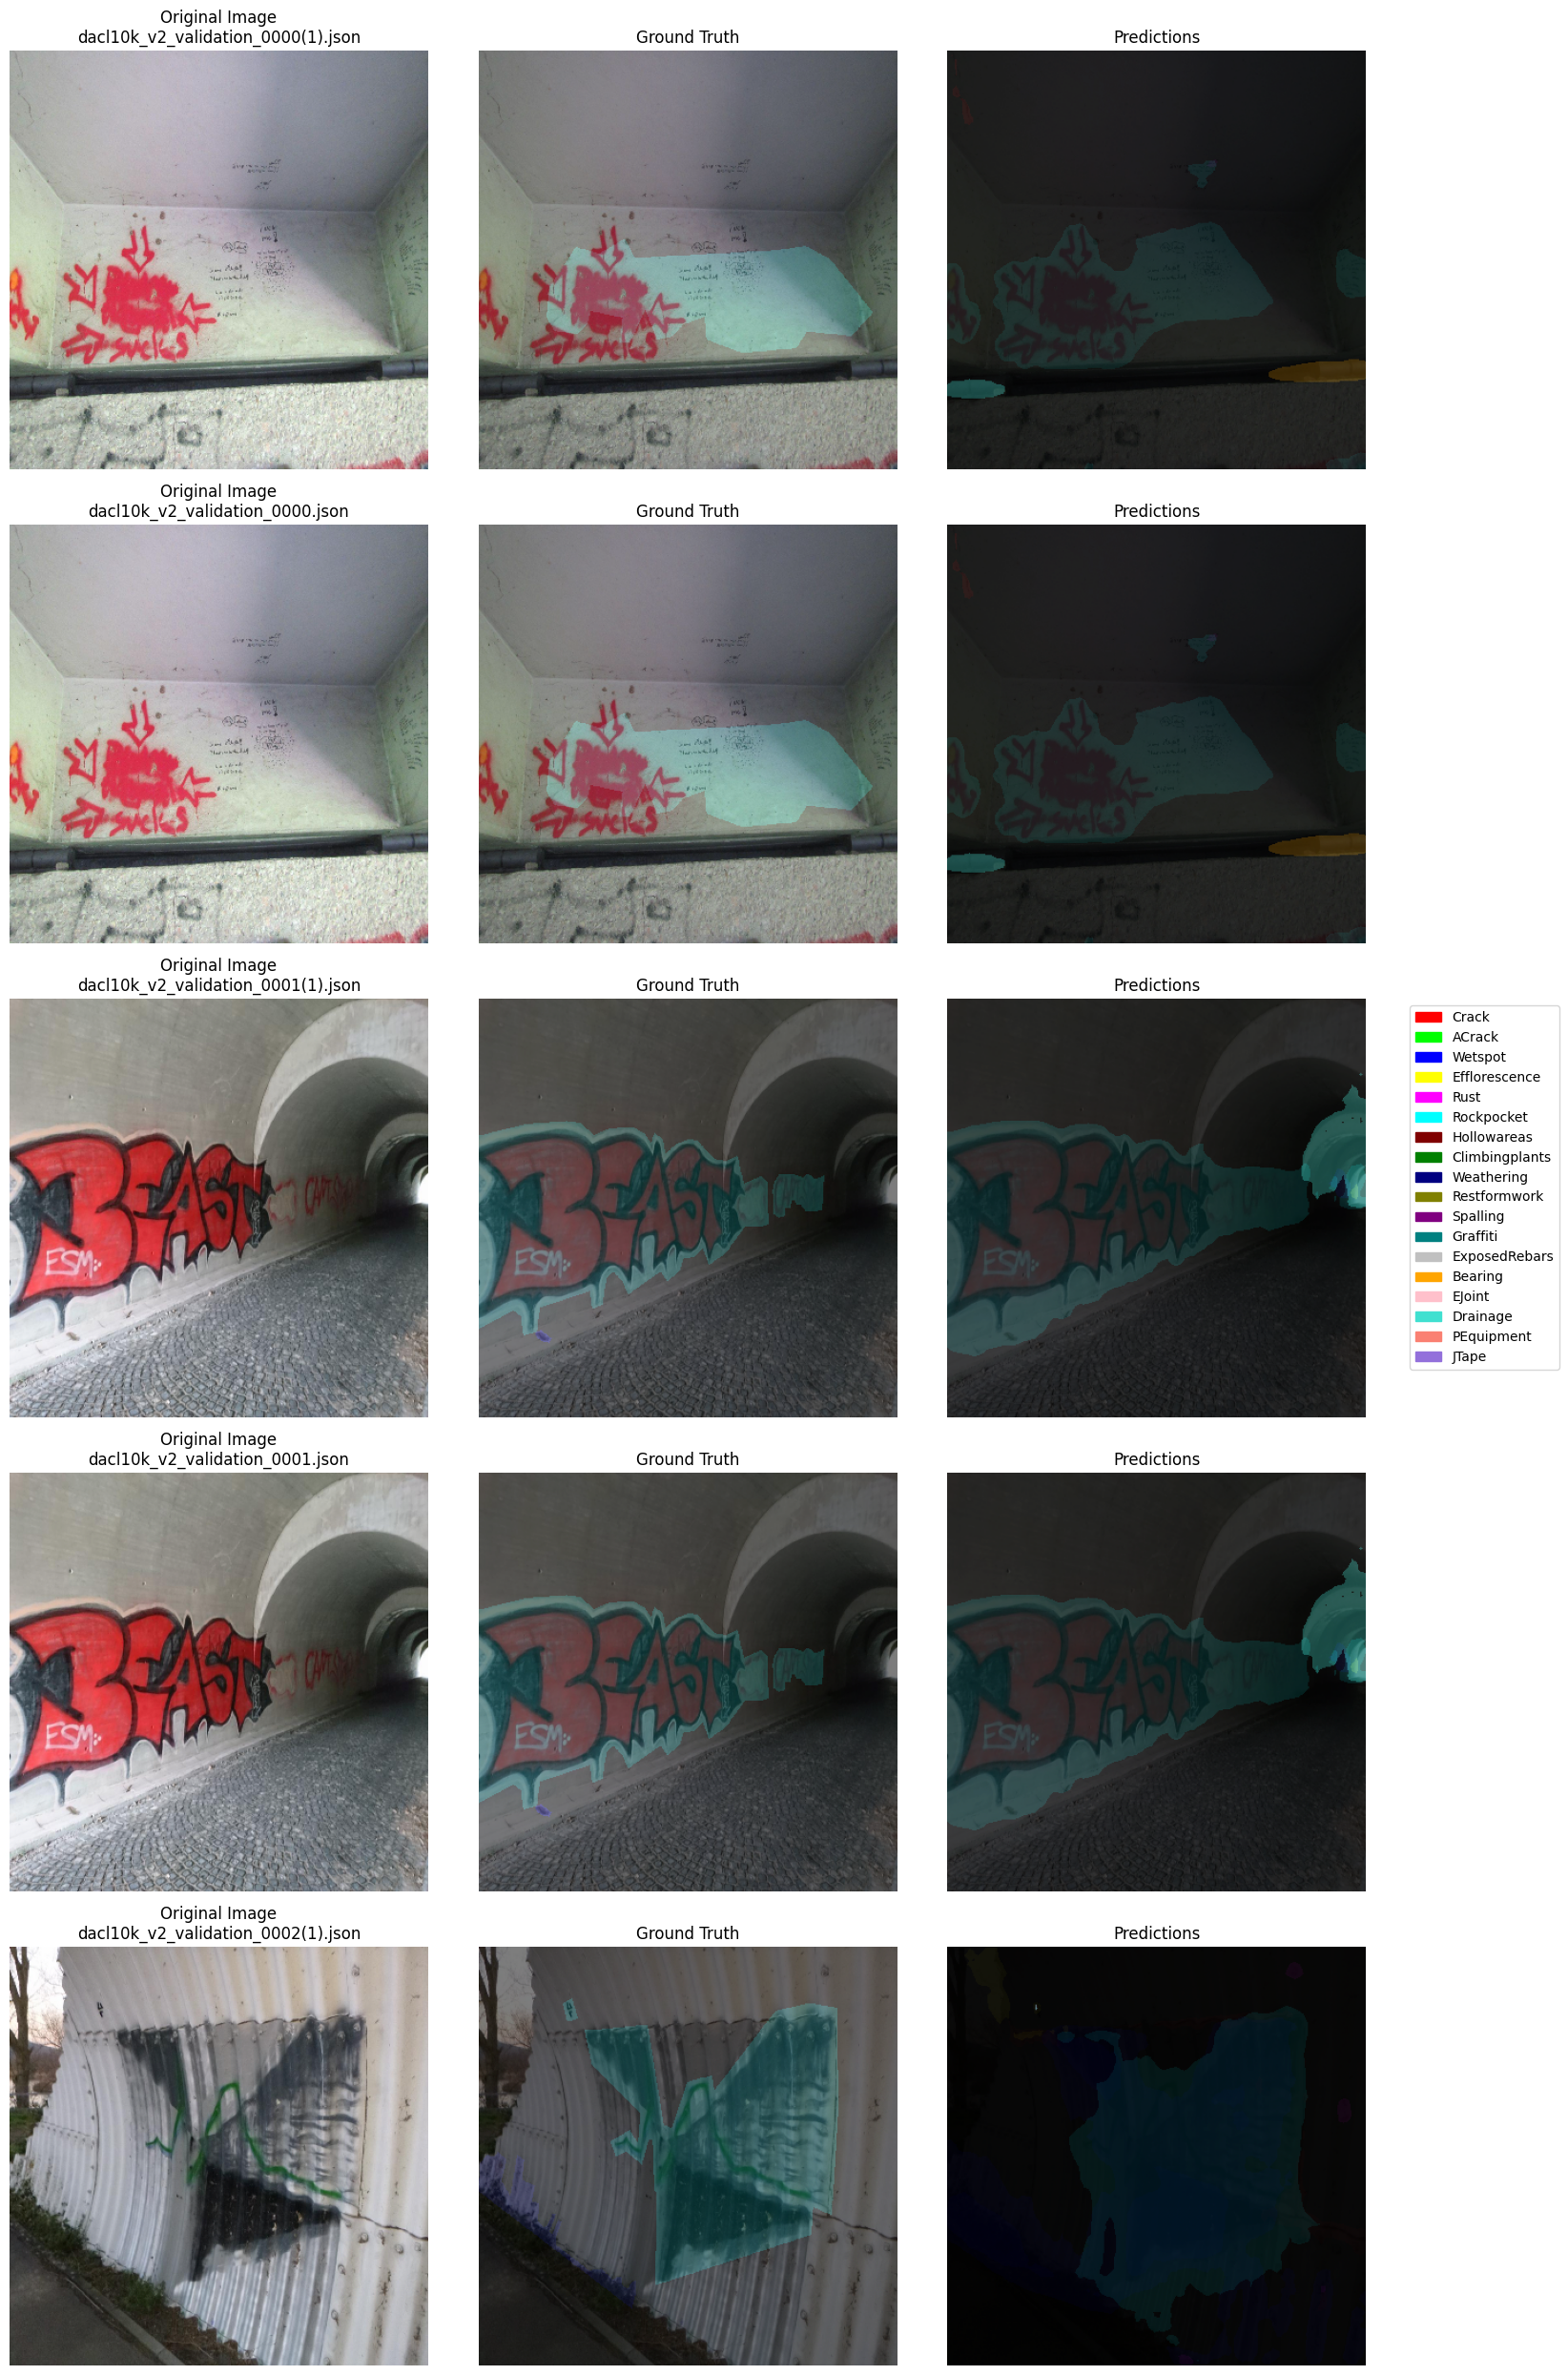

Saved: predictions_output/dacl10k_v2_validation_0000(1)_prediction.png
  Detected classes: Crack, Spalling, Graffiti, Bearing, Drainage
Saved: predictions_output/dacl10k_v2_validation_0000_prediction.png
  Detected classes: Crack, Spalling, Graffiti, Bearing, Drainage
Saved: predictions_output/dacl10k_v2_validation_0001(1)_prediction.png
  Detected classes: Efflorescence, Weathering, Graffiti, Drainage
Saved: predictions_output/dacl10k_v2_validation_0001_prediction.png
  Detected classes: Efflorescence, Weathering, Graffiti, Drainage
Saved: predictions_output/dacl10k_v2_validation_0002(1)_prediction.png
  Detected classes: Crack, Wetspot, Efflorescence, Rust, Weathering, Spalling, Graffiti, ExposedRebars, Drainage


In [10]:
import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

# ----------------------- Config -----------------------
VAL_IMG_DIR = r"C:/Mohamed-7-multi defect-SAM/dataset/images/validation"
VAL_JSON = r"C:/Mohamed-7-multi defect-SAM/dataset/annotations/validation"
MODEL_PATH = "best_model_stable.pth"

CLASS_NAMES = [
    'Crack','ACrack','Wetspot','Efflorescence','Rust','Rockpocket','Hollowareas',
    'Climbingplants','Weathering','Restformwork','Spalling','Graffiti',
    'ExposedRebars','Bearing','EJoint','Drainage','PEquipment','JTape'
]

# Define colors for each class (RGB)
CLASS_COLORS = [
    (255, 0, 0),      # Crack - Red
    (0, 255, 0),      # ACrack - Green
    (0, 0, 255),      # Wetspot - Blue
    (255, 255, 0),    # Efflorescence - Yellow
    (255, 0, 255),    # Rust - Magenta
    (0, 255, 255),    # Rockpocket - Cyan
    (128, 0, 0),      # Hollowareas - Dark Red
    (0, 128, 0),      # Climbingplants - Dark Green
    (0, 0, 128),      # Weathering - Dark Blue
    (128, 128, 0),    # Restformwork - Olive
    (128, 0, 128),    # Spalling - Purple
    (0, 128, 128),    # Graffiti - Teal
    (192, 192, 192),  # ExposedRebars - Silver
    (255, 165, 0),    # Bearing - Orange
    (255, 192, 203),  # EJoint - Pink
    (64, 224, 208),   # Drainage - Turquoise
    (250, 128, 114),  # PEquipment - Salmon
    (147, 112, 219),  # JTape - Medium Purple
]

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_SIZE = 384
THRESHOLD = 0.5

# Copy necessary functions from training code
LABEL_NORMALIZE = {
    'crack':'Crack','acrack':'ACrack','wetspot':'Wetspot','efflorescence':'Efflorescence',
    'rust':'Rust','rockpocket':'Rockpocket','hollowareas':'Hollowareas','hollowarea':'Hollowareas',
    'climbingplants':'Climbingplants','climbingplant':'Climbingplants','weathering':'Weathering',
    'restformwork':'Restformwork','spalling':'Spalling','graffiti':'Graffiti',
    'exposedrebars':'ExposedRebars','exposed_rebars':'ExposedRebars',
    'bearing':'Bearing','ejoint':'EJoint','expansionjoint':'EJoint','drainage':'Drainage',
    'pequipment':'PEquipment','protectiveequipment':'PEquipment','jtape':'JTape','jointtape':'JTape',
}
NAME_TO_IDX = {n:i for i,n in enumerate(CLASS_NAMES)}
NUM_CLASSES = len(CLASS_NAMES)

def polygons_to_mask(shapes, H, W):
    mask = np.zeros((H, W, NUM_CLASSES), dtype=np.float32)
    for sh in shapes:
        lb_raw = (sh.get('label','') or '').replace(' ','')
        lb = LABEL_NORMALIZE.get(lb_raw.lower(), None)
        if lb is None or lb not in NAME_TO_IDX:
            continue
        ci = NAME_TO_IDX[lb]
        pts = sh.get('points', [])
        if not pts:
            continue
        img = Image.new('L', (W, H), 0)
        draw = ImageDraw.Draw(img)
        poly = [(int(x), int(y)) for x,y in pts]
        if len(poly) >= 3:
            draw.polygon(poly, outline=1, fill=1)
        arr = np.array(img, dtype=np.float32)
        mask[:, :, ci] = np.maximum(mask[:, :, ci], arr)
    return mask

# Simple dataset without augmentation for testing
class SimpleValDataset:
    def __init__(self, img_dir, ann_dir):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.files = sorted([f for f in os.listdir(ann_dir) if f.endswith(".json")])
        self.transform = A.Compose([
            A.Resize(IMAGE_SIZE, IMAGE_SIZE),
            A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
            ToTensorV2()
        ])
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        ann_file = self.files[idx]
        ann_path = os.path.join(self.ann_dir, ann_file)
        with open(ann_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        H = int(data.get('imageHeight', 0) or 0)
        W = int(data.get('imageWidth', 0) or 0)
        shapes = data.get('shapes', [])
        img_name = data.get('imagePath', os.path.splitext(ann_file)[0])
        
        # Find image file
        base = os.path.splitext(os.path.basename(img_name))[0]
        img_path = None
        for ext in ('.jpg','.jpeg','.png','.JPG','.PNG','.JPEG'):
            p = os.path.join(self.img_dir, base + ext)
            if os.path.exists(p):
                img_path = p
                break
        
        # Load image
        bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        if H == 0 or W == 0:
            H, W = rgb.shape[:2]
        
        # Create mask
        mask_hwc = polygons_to_mask(shapes, H, W)
        
        # Apply transforms
        aug = self.transform(image=rgb, mask=mask_hwc)
        image = aug['image']
        mask = aug['mask']
        
        # Handle mask conversion properly
        if isinstance(mask, torch.Tensor):
            # If already a tensor, ensure it's in CHW format
            if mask.shape[-1] == NUM_CLASSES:  # HWC
                mask_t = mask.permute(2, 0, 1).float()
            else:  # Already CHW
                mask_t = mask.float()
        else:
            # If numpy array, convert to tensor
            mask_t = torch.from_numpy(mask).permute(2, 0, 1).float()
        
        return image, mask_t, ann_file

# ----------------------- Evaluation Function -----------------------
@torch.no_grad()
def calculate_miou(model, dataset):
    """Calculate mIoU and per-class IoU"""
    model.eval()
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    inter = torch.zeros(NUM_CLASSES, dtype=torch.float64)
    union = torch.zeros(NUM_CLASSES, dtype=torch.float64)
    
    print("Calculating mIoU...")
    for img, mask, _ in loader:
        img = img.to(DEVICE)
        mask = mask.to(DEVICE)
        
        # Get predictions
        logits = model(img)
        probs = torch.sigmoid(logits)
        preds = (probs > THRESHOLD).float()
        
        # Calculate intersection and union
        inter += (preds * mask).sum(dim=(0,2,3)).cpu()
        union += ((preds + mask) > 0).float().sum(dim=(0,2,3)).cpu()
    
    # Calculate IoU
    iou = (inter / (union.clamp_min(1e-6))).numpy()
    miou = float(np.mean(iou))
    
    return miou, iou

# ----------------------- Visualization Function -----------------------
def visualize_predictions(model, dataset, num_images=5):
    """Visualize predictions on sample images"""
    model.eval()
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5*num_images))
    if num_images == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (img, mask, filename) in enumerate(loader):
        if idx >= num_images:
            break
        
        img = img.to(DEVICE)
        
        # Get predictions
        with torch.no_grad():
            logits = model(img)
            probs = torch.sigmoid(logits)
            preds = (probs > THRESHOLD).float()
        
        # Convert to numpy
        img_np = img[0].cpu().numpy().transpose(1, 2, 0)
        img_np = (img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
        img_np = np.clip(img_np, 0, 255).astype(np.uint8)
        
        mask_np = mask[0].cpu().numpy()  # (C, H, W)
        preds_np = preds[0].cpu().numpy()  # (C, H, W)
        
        # Create overlay images
        gt_overlay = img_np.copy()
        pred_overlay = img_np.copy()
        
        # Apply colors to ground truth and predictions
        for c in range(NUM_CLASSES):
            if mask_np[c].sum() > 0:  # Ground truth
                color_mask = np.zeros_like(gt_overlay)
                color_mask[mask_np[c] > 0] = CLASS_COLORS[c]
                gt_overlay = cv2.addWeighted(gt_overlay, 0.7, color_mask, 0.3, 0)
            
            if preds_np[c].sum() > 0:  # Predictions
                color_mask = np.zeros_like(pred_overlay)
                color_mask[preds_np[c] > 0] = CLASS_COLORS[c]
                pred_overlay = cv2.addWeighted(pred_overlay, 0.7, color_mask, 0.3, 0)
        
        # Plot
        axes[idx, 0].imshow(img_np)
        axes[idx, 0].set_title(f'Original Image\n{filename[0]}')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(gt_overlay)
        axes[idx, 1].set_title('Ground Truth')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(pred_overlay)
        axes[idx, 2].set_title('Predictions')
        axes[idx, 2].axis('off')
    
    # Create legend
    legend_elements = []
    for i, (name, color) in enumerate(zip(CLASS_NAMES, CLASS_COLORS)):
        color_normalized = tuple(c/255.0 for c in color)
        legend_elements.append(mpatches.Patch(color=color_normalized, label=name))
    
    plt.figlegend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    plt.show()

# ----------------------- Main Testing Function -----------------------
def test_model():
    print(f"Loading model from {MODEL_PATH}...")
    
    # Load checkpoint
    checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
    
    # Create model
    model = smp.FPN(
        encoder_name="efficientnet-b4",
        encoder_weights=None,  # Don't load pretrained weights
        in_channels=3,
        classes=NUM_CLASSES
    ).to(DEVICE)
    
    # Load weights
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    
    print(f"Model loaded successfully!")
    print(f"Saved mIoU from training: {checkpoint.get('best_mIoU', 'N/A'):.4f}")
    print(f"Saved at epoch: {checkpoint.get('epoch', 'N/A')}")
    
    # Create dataset
    print("\nLoading validation dataset...")
    dataset = SimpleValDataset(VAL_IMG_DIR, VAL_JSON)
    print(f"Found {len(dataset)} validation images")
    
    # Calculate mIoU
    print("\nCalculating real mIoU on validation set...")
    miou, iou_per_class = calculate_miou(model, dataset)
    
    print(f"\n{'='*50}")
    print(f"Real Validation mIoU: {miou:.4f}")
    print(f"{'='*50}")
    print("\nPer-class IoU:")
    for i, (name, iou) in enumerate(zip(CLASS_NAMES, iou_per_class)):
        print(f"  {name:15s} IoU: {iou:.3f}")
    
    # Visualize predictions
    print("\nVisualizing predictions on 5 sample images...")
    visualize_predictions(model, dataset, num_images=5)
    
    # Save individual predictions if needed
    save_individual = input("\nDo you want to save individual prediction images? (y/n): ").lower()
    if save_individual == 'y':
        save_predictions(model, dataset, num_images=5)

def save_predictions(model, dataset, num_images=5):
    """Save prediction images to disk"""
    model.eval()
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    # Create output directory
    os.makedirs('predictions_output', exist_ok=True)
    
    for idx, (img, mask, filename) in enumerate(loader):
        if idx >= num_images:
            break
        
        img = img.to(DEVICE)
        
        # Get predictions
        with torch.no_grad():
            logits = model(img)
            probs = torch.sigmoid(logits)
            preds = (probs > THRESHOLD).float()
        
        # Convert to numpy
        img_np = img[0].cpu().numpy().transpose(1, 2, 0)
        img_np = (img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
        img_np = np.clip(img_np, 0, 255).astype(np.uint8)
        
        preds_np = preds[0].cpu().numpy()  # (C, H, W)
        
        # Create prediction overlay
        pred_overlay = img_np.copy()
        
        # Track which classes are present
        present_classes = []
        
        # Apply colors to predictions
        for c in range(NUM_CLASSES):
            if preds_np[c].sum() > 0:
                present_classes.append(CLASS_NAMES[c])
                color_mask = np.zeros_like(pred_overlay)
                color_mask[preds_np[c] > 0] = CLASS_COLORS[c]
                pred_overlay = cv2.addWeighted(pred_overlay, 0.7, color_mask, 0.3, 0)
        
        # Save image
        base_name = os.path.splitext(filename[0])[0]
        output_path = f'predictions_output/{base_name}_prediction.png'
        cv2.imwrite(output_path, cv2.cvtColor(pred_overlay, cv2.COLOR_RGB2BGR))
        
        print(f"Saved: {output_path}")
        print(f"  Detected classes: {', '.join(present_classes) if present_classes else 'None'}")

# ----------------------- Run the test -----------------------
if __name__ == "__main__":
    test_model()